# Project 2: Reproducibility in Natural Language Processing



### Read Data

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('seaborn-v0_8-dark') 

In [2]:
# read in SOTU.csv using pandas, name the variable `sou` for simplicity
sou = pd.read_csv("data/SOTU.csv")
sou.head()

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169


## Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization (20 pts)

Now we will start working on simple text processing using the `SpaCy` package and the same dataset as Part 1. The package should already be included in the `environment.yml`. However, we will also need to download `en_core_web_sm`, an English language text processing model. To do this, while having your `sotu` environment activated, run the following:

```
python -m spacy download en_core_web_sm
```

Now, you should be good to go!

Some important definitions:

- *Token*: a single word or piece of a word
- *Lemma*: the core component of a word, e.g., "complete" is the lemma for "completed" and "completely"
- *Stop Word*: a common word that does not add semantic value, such as "a", "and", "the", etc.
- *Vectorization*: representing a document as a vector where each index in the vector corresponds to a token or word and each entry is the count.

In this section, we will explore the most common tokens and lemmas throughout different slices of the speech data. We will also develop vectorization representations of the speeches. 

 The core steps are:

1. Process speeches using the SpaCy nlp module
2. Analyze Tokens vs Lemmas:
- Create a list of all tokens across all speeches that are not stop words, punctuation, or spaces.
- Create a second list of the lemmas for these same tokens.
- Display the top 25 for each of these and compare.
3. Analyze common word distributions over different years:
- Create a function that takes the dataset and a year as an input and outputs the top n lemmas for that year's speeches
- Compare the top 10 words for 2023 versus 2017 (Fixed the typo from 2023 to 2019 here as the hint is for 2017)
4. Document Vectorization:
- Train a Term Frequency-Inverse Document Frequency (TF-IDF) vectorization model using your processed dataset and scikit learn
- Output the feature vectors 

**Helpful Resources:**
- https://realpython.com/natural-language-processing-spacy-python/
- https://www.statology.org/text-preprocessing-feature-engineering-spacy/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html# 
- https://www.geeksforgeeks.org/nlp/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/ 



### Processing Speeches with SpaCy

Lets study just speeches from 2000 and onwards to begin with. So, be sure to subset your DataFrame to just these speeches before continuing!

In [3]:
import sys
# sys.executable for the correct Python for the environment
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.2 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
from collections import Counter
from tqdm import tqdm
import spacy

# subset the speech dataframe for speeches from 2000 and onwards
sou_2000 = sou[sou["Year"] >= 2000].copy()

# Process each speeches using the 'nlp' function
nlp = spacy.load("en_core_web_sm")

# loop through each speech and pass the text into the nlp function above, storing the output in a list
processed_docs = []
for text in tqdm(sou_2000["Text"], desc = "Processing speeches"):
    doc = nlp(text)
    processed_docs.append(doc)

Processing speeches: 100%|██████████| 25/25 [00:26<00:00,  1.04s/it]


### Analyze Tokens vs Lemmas

#### Token List

Create a list of tokens across all speeches that are not spaces, stopwords, or punctuation. Make each token lowercase as well. *Hint: each element of the list we just created are themselves lists of tokens. Token objects have attributes `is_stop`, `is_punct`, and `is_space`.*

In [5]:
example_text = sou.loc[0, "Text"]

doc = nlp(example_text)

tokens = [token.text for token in doc]
tokens[:50]  # preview first 50 tokens

['\n',
 '[',
 'Before',
 'speaking',
 ',',
 'the',
 'President',
 'presented',
 'his',
 'prepared',
 'remarks',
 'to',
 'Speaker',
 'of',
 'the',
 'House',
 'of',
 'Representatives',
 'J.',
 'Michael',
 'Johnson',
 '.',
 ']',
 '\n',
 'The',
 'President',
 '.',
 'Your',
 'bedtime',
 'reading',
 '.',
 '\n',
 'Tony',
 '!',
 'Thank',
 'you',
 '.',
 'Looking',
 'for',
 'Jill',
 '.',
 '\n',
 'Good',
 'evening',
 '.',
 'Good',
 'evening',
 '.',
 'If',
 'I']

In [6]:
tokens = []

for doc in processed_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            tokens.append(token.text.lower())

token_counts = Counter(tokens)
# print top 25 tokens
token_counts.most_common(25)

[('america', 816),
 ('people', 637),
 ('american', 582),
 ('new', 530),
 ('years', 439),
 ('americans', 437),
 ('world', 425),
 ('year', 406),
 ('country', 369),
 ('jobs', 348),
 ('tonight', 344),
 ('work', 324),
 ('know', 323),
 ('let', 320),
 ('congress', 317),
 ('nation', 311),
 ('time', 301),
 ('help', 282),
 ('need', 266),
 ('tax', 255),
 ('president', 247),
 ('economy', 243),
 ('like', 241),
 ('right', 240),
 ('want', 237)]

#### Lemma List

Do the same as above, but for lemmas. *Hint: recall lemmas are components of words. Each token should have an attribute to extract the lemma.*

In [7]:
lemmas = []

for doc in processed_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            lemmas.append(token.lemma_.lower())

lemma_counts = Counter(lemmas)
lemma_counts.most_common(25)

[('year', 845),
 ('america', 816),
 ('people', 639),
 ('american', 587),
 ('work', 557),
 ('new', 532),
 ('job', 486),
 ('country', 435),
 ('americans', 432),
 ('world', 426),
 ('know', 395),
 ('nation', 388),
 ('help', 378),
 ('need', 353),
 ('time', 351),
 ('tonight', 344),
 ('child', 332),
 ('let', 326),
 ('congress', 317),
 ('come', 301),
 ('family', 296),
 ('good', 294),
 ('right', 282),
 ('million', 274),
 ('want', 264)]

#### Token versus Lemma Comparison

What do you notice about the top tokens versus the top lemmas? 
Consider two tokens - "year" and "years" - how do their counts compare to the lemma "year"?
What about the lemma "child"?

Looking at the top tokens and top lemmas, the main difference is that tokens keep every word form separate, while lemmas merge different forms of the same word into one base form. For example, in the token list “year” and “years” appear as two separate entries (406 for “year” and 439 for “years”), but the lemma list combines them into a single lemma, “year,” which combine to the total count of 845. This shows that lemmatization combines different versions of a word into one main form. Something similar happens with “child”: the token list does not show “child” in the top 20 because forms like “child,” “children,” and “child’s” appear separately and are not individually frequent enough. But once lemmatized, all of these forms map to the single lemma “child,” which rises to 332 occurrences and appears in the top lemma list. Overall, tokens capture surface-level frequency, while lemmas give a clearer picture of the underlying concepts being used in the speeches.

### Analyze common word distributions over different years

#### Common Words per Year Function

Fill in the below function to obtain the n-most common words in speeches for a given year.

inputs: 
- df raw unprocessed sou dataframe
- year
- n
outputs: 
- top n words for that years

steps:
- subset the dataframe for the year of interest - note the years might not be in int type
- process the subsetted dataframe with spacy
- get the lemmas across all those speeches
- count the top n lemmas

In [8]:
def get_most_common_words(df, year, n=25):
    """
    Processes the SOTU speeches for a given year and returns
    the most common non-stopword / non-punctuation lemmas.
    """

    # Step 1: Subset df for the chosen year 
    df_year = df[df["Year"].astype(int) == int(year)].copy()

    # Step 2: Process the text with spaCy
    docs = [nlp(text) for text in df_year["Text"]]

    # Step 3: Extract lemmas (remove stopwords, punctuation, and spaces)
    lemmas = []
    for doc in docs:
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space:
                lemmas.append(token.lemma_.lower())

    counts = Counter(lemmas)
    return counts.most_common(n)

In [9]:
# test it on 2024
# Consulted Jummy, and he said it's fine to do n=20 vs n=10 in expected output
get_most_common_words(sou, 2024, n=20)

[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29),
 ('pay', 29),
 ('come', 26),
 ('home', 25),
 ('family', 24),
 ('future', 23),
 ('million', 23),
 ('like', 21),
 ('build', 21),
 ('laughter', 20),
 ('americans', 20)]

#### Compare 2023 to 2017

Run your function from the previous step to get the top 20 words for 2017 and 2023. Plot the words and their frequencies in a barchart and replicate the figure below.

In [10]:
words_2023 = get_most_common_words(sou, 2023, n=20)
words_2017 = get_most_common_words(sou, 2017, n=20)

In [11]:
words_2023

[('year', 58),
 ('go', 56),
 ('let', 45),
 ('know', 40),
 ('people', 39),
 ('job', 38),
 ('america', 36),
 ('come', 33),
 ('law', 33),
 ('pay', 33),
 ('american', 31),
 ('$', 31),
 ('president', 30),
 ('look', 27),
 ('world', 25),
 ('folk', 24),
 ('nation', 24),
 ('audience', 23),
 ('work', 23),
 ('right', 23)]

In [12]:
words_2017

[('american', 34),
 ('america', 29),
 ('country', 26),
 ('nation', 21),
 ('great', 20),
 ('new', 19),
 ('year', 19),
 ('world', 18),
 ('job', 15),
 ('people', 15),
 ('americans', 14),
 ('united', 13),
 ('tonight', 13),
 ('states', 12),
 ('work', 12),
 ('child', 12),
 ('want', 12),
 ('time', 12),
 ('citizen', 11),
 ('right', 11)]

In [13]:
# Put the words and counts into a pd Dataframe for better structure
# and to make plotting easier
df_2017 = pd.DataFrame(words_2017, columns=["word", "count"])
df_2023 = pd.DataFrame(words_2023, columns=["word", "count"])

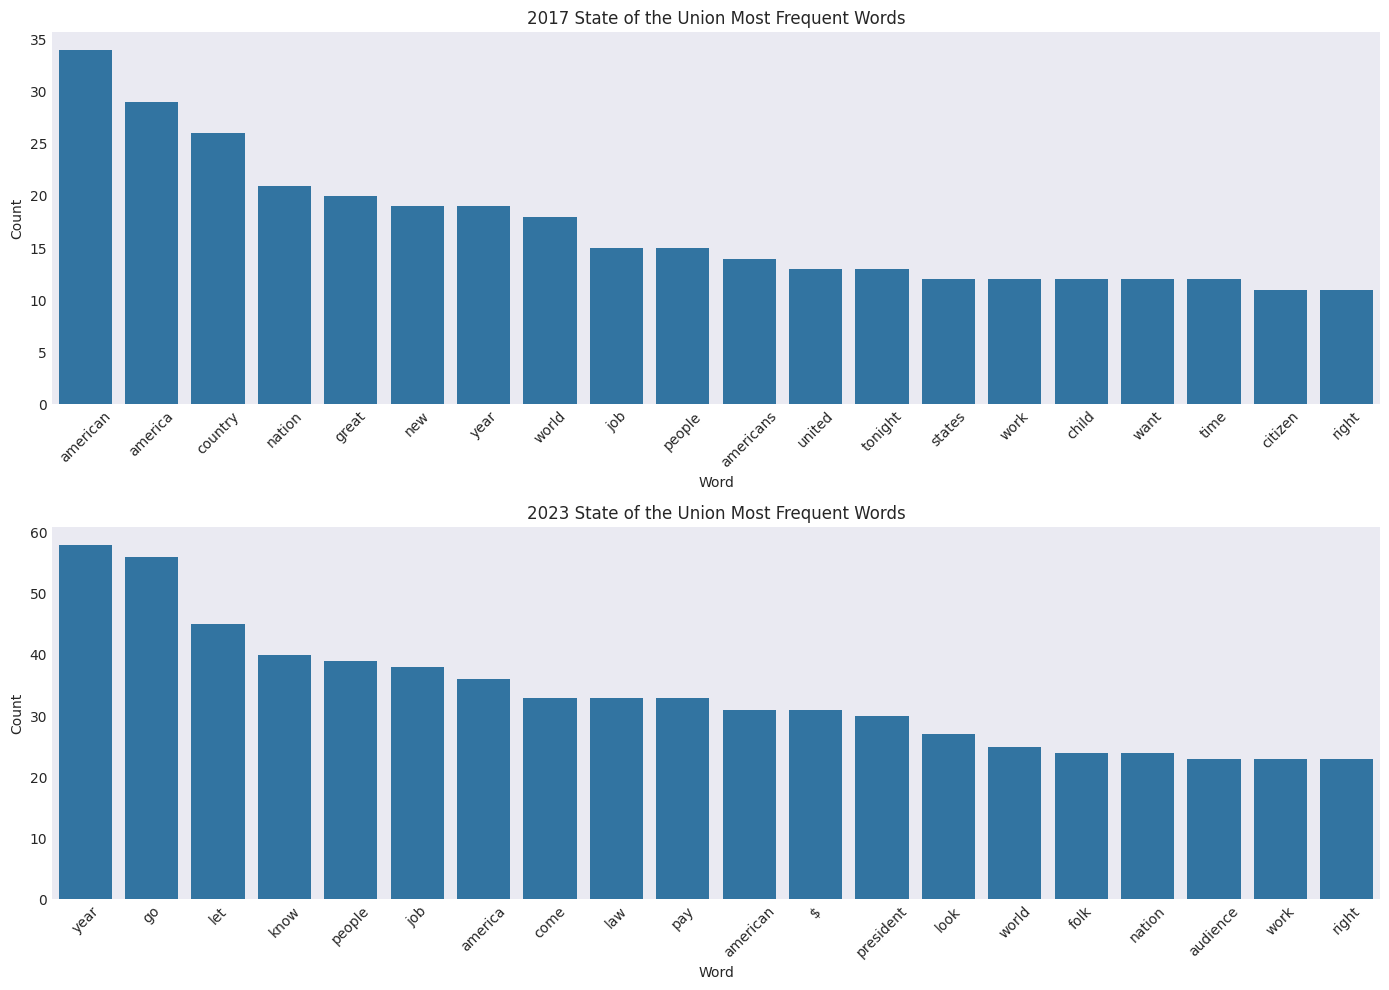

In [14]:
# Hint - use seaborn, subplots, and rotate tick labels
plt.figure(figsize=(14, 10))

# plot of 2017
plt.subplot(2, 1, 1)
sns.barplot(data=df_2017, x="word", y="count")
plt.xticks(rotation=45)
plt.title("2017 State of the Union Most Frequent Words")
plt.xlabel("Word")
plt.ylabel("Count")

# plot of 2023
plt.subplot(2, 1, 2)
sns.barplot(data=df_2023, x="word", y="count")
plt.xticks(rotation=45)
plt.title("2023 State of the Union Most Frequent Words")
plt.xlabel("Word")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig("outputs/barplot_2017vsbarplot_2023.png")
plt.show()

### Document Vectorization (TF-IDF Vectorization)

To use statsitical alorithms on documents, we need to transform them into vectors, where each element of the vector corresponds to a particular word in a document or corpus of documents. One common way is via TF-IDF embeddings. LLMs work similarly - they typically use transformer models to generate text embeddings before sending text through a deep neural network. 

Here we will fit a TF-IDF vectorizer, plot all the speeches on a 2-D grid using PCA and also using a heatmap, and examine TF-IDF scores for the top 10 most common words in the first speech. This is a good resource here: https://medium.com/GeoffreyGordonAshbrook/vector-visualization-2d-plot-your-tf-idf-with-pca-83fa9fccb1d 

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

#### Train the Vectorizer and Transform the Data

In [16]:
# you may use this as input to fit the TF-IDF vectorizer
raw_docs = sou["Text"].tolist()
vectorizer = TfidfVectorizer()
# Hint - use fit_transform for vectorizer and PCA
tfidf_matrix = vectorizer.fit_transform(raw_docs)

The output of `fit_transform()` will be a matrix where each row corresponds to a speech, each column corresponds to a word in the corpus of speeches, and the value is the TF-IDF score which measures the importance of that word in that speech, relative to the rest of the speeches.

#### Plot Speeches

- First used PCA to generate the first chart
- Second use seaborn heatmap with a log-scaled color axis to generate the second chart

Folder 'outputs' already exists.


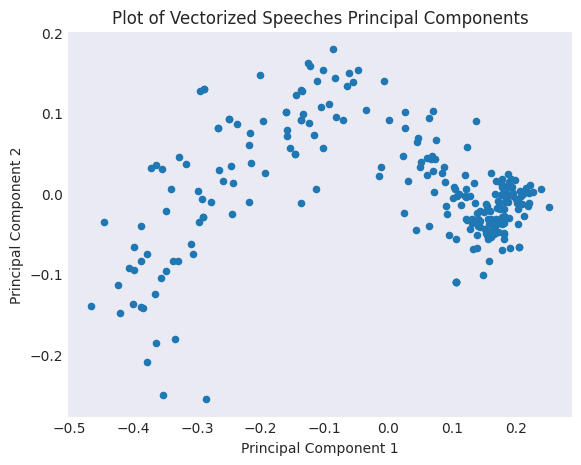

In [17]:
# Step 1: Set PCA to find first 2 principal components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(tfidf_matrix.toarray())

# Step 2: Create a new dataframe where each row is a speech, and
# each column is a projection onto one of the two principal components
pca_df = pd.DataFrame({
    "PC1": pca_components[:, 0],
    "PC2": pca_components[:, 1]
})

# Step 3: Plot Data Visualization (Matplotlib)
plt.figure(figsize=(6.5, 5))
plt.scatter(pca_df["PC1"], pca_df["PC2"],s=20)
plt.title("Plot of Vectorized Speeches Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(False)

# make the folder called "outputs" if not exists
folder_name = "outputs"

# Check if the folder already exists
if not os.path.exists(folder_name):
    # If it doesn't exist, create it
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

plt.savefig("outputs/plot_of_vectorized_speeches.png")

plt.show()

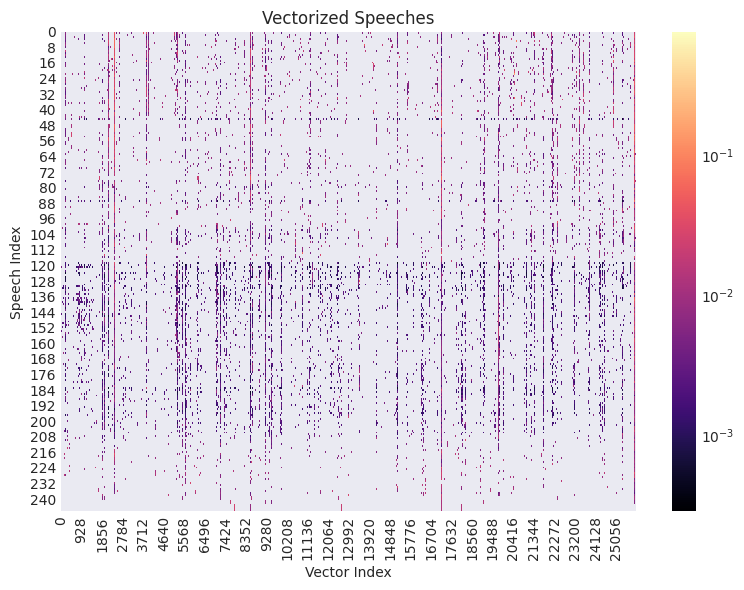

In [18]:
# Hint - vectorized_docs is a sparse matrix whose rows are speeches and columns are tokens, with each
# value being a TF-IDF score. Densify this array first, and then plot using seaborn.
tfidf_dense = tfidf_matrix.toarray()

plt.figure(figsize=(8, 6))

ax = sns.heatmap(
    tfidf_dense,
    cmap="magma",
    norm="log",
    cbar_kws={}
)

# create tick positions in multiples of 928
tick_step = 928
ticks = np.arange(0, tfidf_dense.shape[1], tick_step)

ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=90)

plt.title("Vectorized Speeches")
plt.xlabel("Vector Index")
plt.ylabel("Speech Index")

plt.tight_layout()

plt.savefig("outputs/vecotorized_speeches.png")

plt.show()

#### Get the TF-IDF value for certain words and documents

In [19]:
word_list = ['year',
 'america',
 'people',
 'american',
 'work',
 'new',
 'job',
 'country',
 'americans',
 'world'] # top ten most common words through whole corpus

In [20]:
word_nums = [vectorizer.vocabulary_[w] for w in word_list]
word_nums

[25879, 2410, 17259, 2412, 25728, 15972, 13576, 6506, 2416, 25753]

In [21]:
idf_score = vectorizer.idf_[word_nums]
idf_score

array([1.03292478, 1.27294637, 1.03711766, 1.10221657, 1.16228081,
       1.0245914 , 2.04348022, 1.00813013, 1.71359779, 1.13875031])

In [22]:
tf_idf = tfidf_matrix[0, word_nums].toarray()[0]
tf_idf

array([0.02271853, 0.06843872, 0.04308698, 0.04579151, 0.00568081,
       0.01627545, 0.00998779, 0.01355028, 0.04187723, 0.02643755])

In [23]:
pd.DataFrame({"Word": word_list, "IDF Score": idf_score, "TF-IDF Score": tf_idf})

,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438
